### imports

In [110]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from ml1_mnist.utils.dataset import load_mnist, plot_mnist_digit
from ml1_mnist.utils.model_selection import TrainTestSplitter
from ml1_mnist.utils.metrics import zero_one_loss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load dataset

In [104]:
X, y = load_mnist(mode='train', path='data/')
X.shape

(60000, 784)

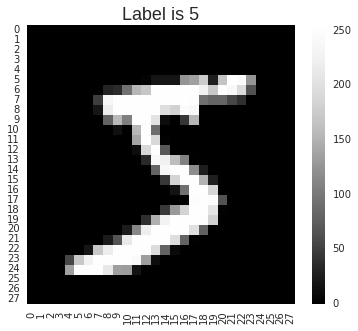

In [105]:
plot_mnist_digit(X[0], y[0])

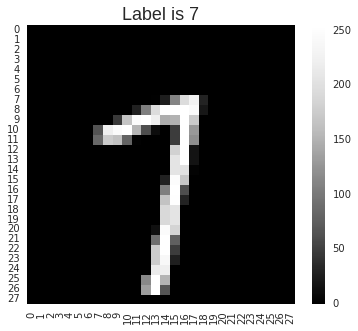

In [106]:
plot_mnist_digit(X[42], y[42])

# k-NN

In [109]:
tts = TrainTestSplitter(shuffle=True, random_seed=1337)
for train, test in tts.k_fold_split(y, n_folds=4, stratify=True):
    print len(train), len(test), len(train) + len(test)

45005 14995 60000
45005 14995 60000
45005 14995 60000
44985 15015 60000
